# Attention Visualization - ViT

Inspired by `Alex Wang`'s Spring 25' recitation / notebook

In [1]:
import torch

import torchvision.transforms as pth_transforms
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

from transformers import ViTModel
from PIL import Image

import requests

# Loading ViT model (facebook/dino-vitb16) from HuggingFace

We are using the Vision Transformer (ViT) model pretrained with DINO from Facebook.

Although pretrained with 224x224 images, ViT allows flexibility:
- By setting `interpolate_pos_encoding=True` during the forward pass, the model interpolates positional embeddings to work with larger inputs like 480x480

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "facebook/dino-vitb16"
model = ViTModel.from_pretrained(model_name, output_attentions=True).to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

# Fetching input image

In [3]:
# Fetch image
url = "https://meet.nyu.edu/wp-content/uploads/2020/06/ImageOne.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# Preprocess: Crop --> Resize -> Normalize

In [4]:
# Apply transformations: Crop --> Resize -> Normalize
transform = pth_transforms.Compose([
    pth_transforms.CenterCrop(min(image.size)),  # Crop to square
    pth_transforms.Resize(480),
    pth_transforms.ToTensor(),
])

tensor_image = transform(image).to(device)

normalized_tensor_image = pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(tensor_image)

pil_img = to_pil_image(tensor_image) # Convert back to PIL for visualization
img_size = tensor_image.shape[-2:]  # (Height, Width)

input_tensor = normalized_tensor_image[None]
inputs = {"pixel_values": input_tensor.to(device)}

Displaying the preprocessed input image:

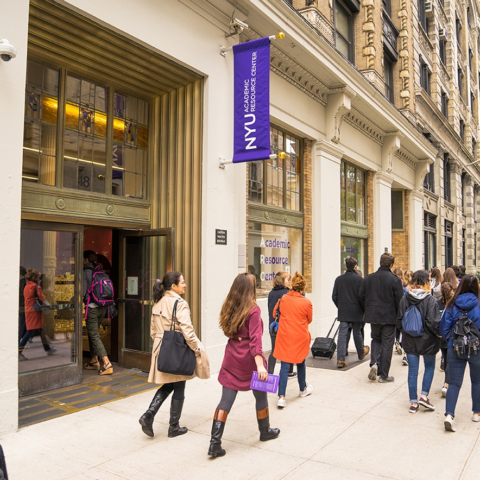

In [5]:
display(pil_img)

# Forward pass through the model and retrieve attention from last transformer block

In [6]:
# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs, interpolate_pos_encoding=True)
    attentions = outputs.attentions  # Extract attention weights


# Extract last layer's attention
attentions = attentions[-1].cpu().detach()
num_heads = attentions.shape[1]

# Remove CLS token (token 0) & reshape
attentions = attentions[0, :, 0, 1:].reshape(num_heads, -1)  # Shape: (num_heads, 1, h//16*w//16)
attentions = attentions.reshape(num_heads, img_size[-1] // 16, img_size[-2] // 16)

# Upscale to original image size
attentions = torch.nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0]

# Normalize attention maps
attentions_normalized = (attentions / torch.amax(attentions, dim=(1, 2), keepdim=True))[:, None].to(device)

`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [7]:
attentions.shape

torch.Size([12, 480, 480])

# Visualizing the attention heads

Each attention head in the last layer focuses on different regions of the image. Below, we visualize all 12 heads to understand how the model distributes its attention. Brighter regions indicate areas of higher attention, showing which parts of the image influence the model's decision most strongly.

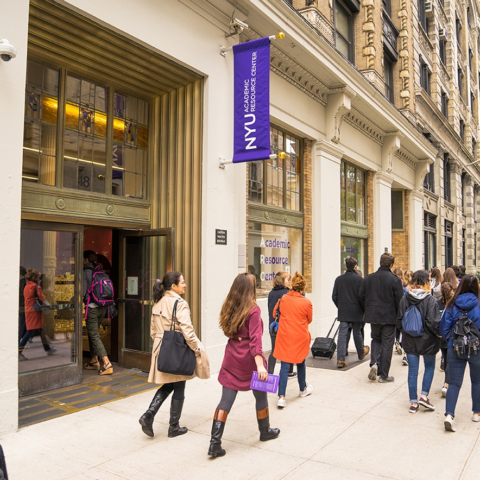

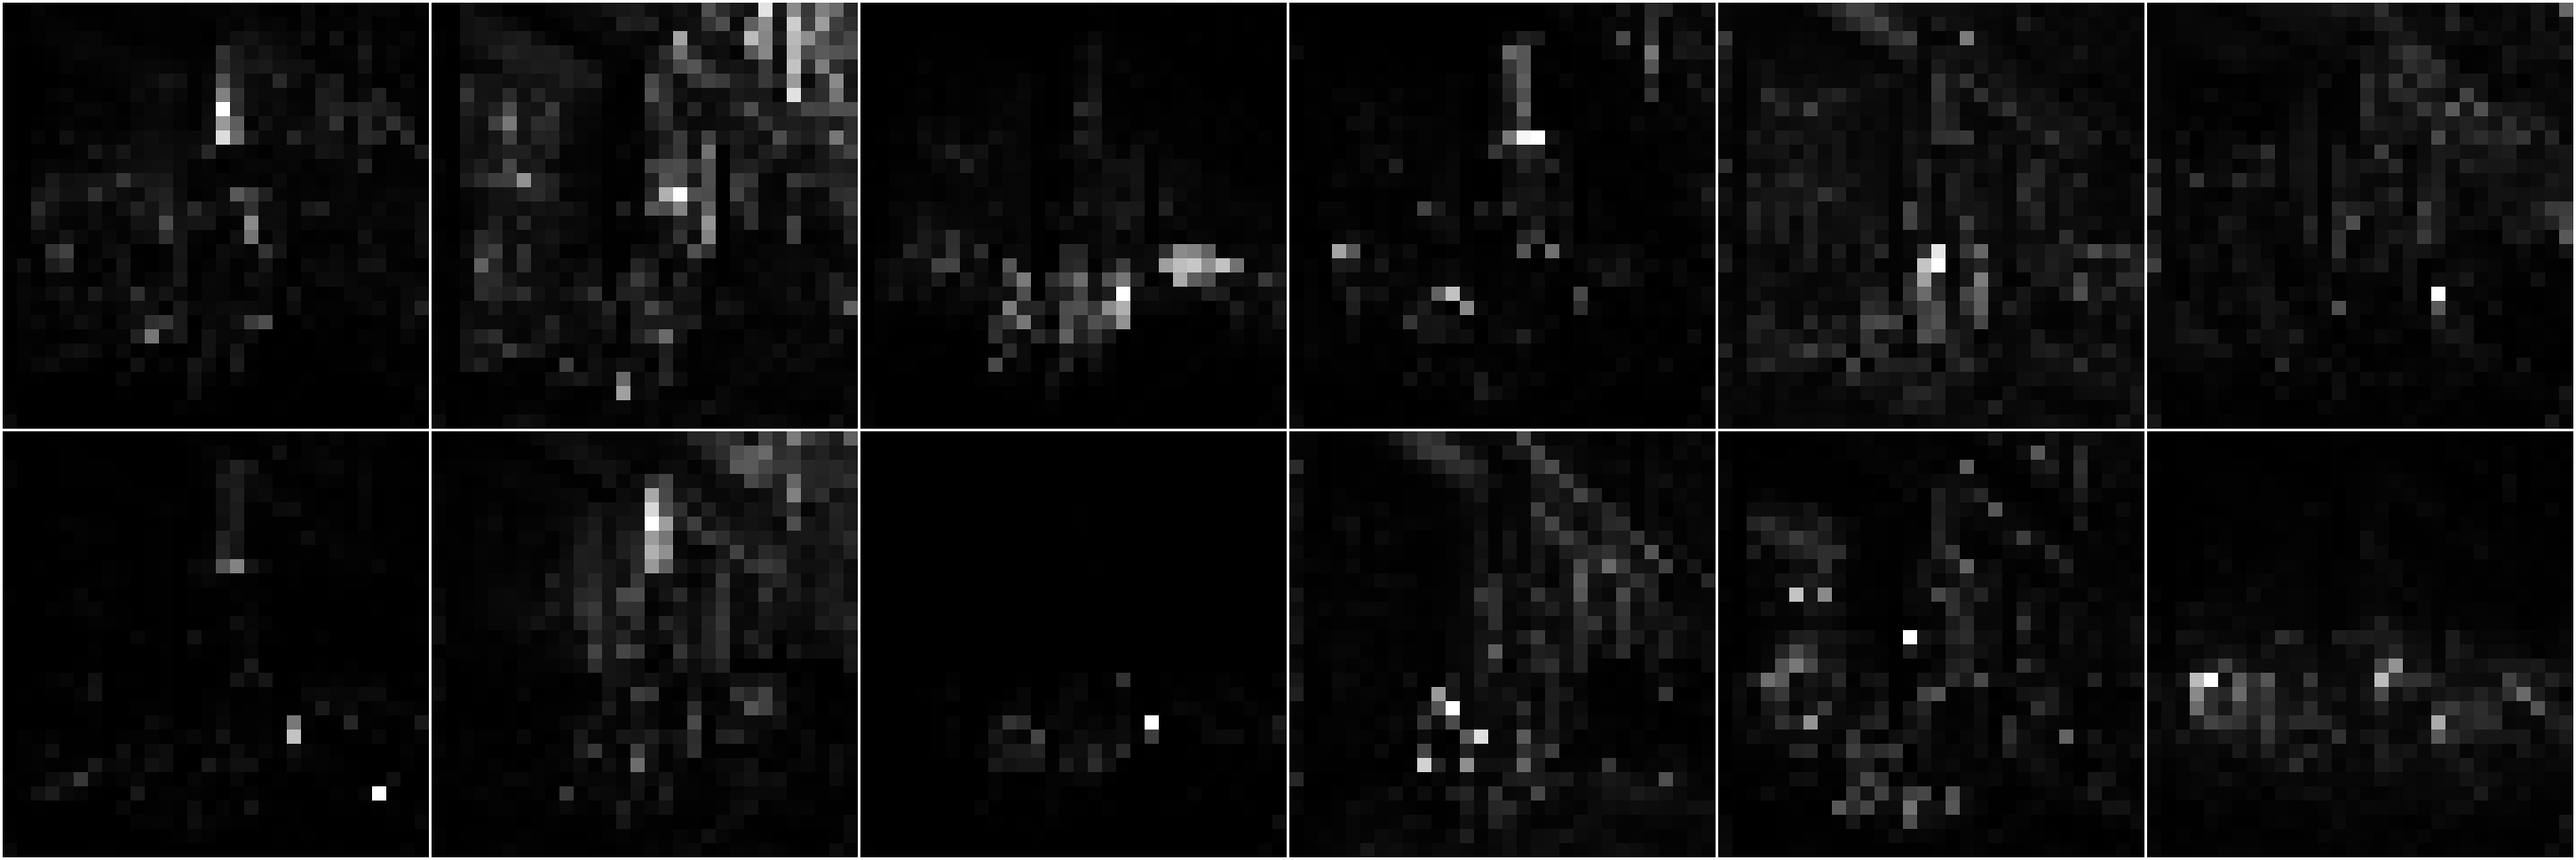

In [8]:
# Display original image
display(pil_img)

# Convert to PIL image and display grid
display(to_pil_image(make_grid(attentions_normalized,
                               pad_value=1., padding=3, nrow=6)))

## Overlaying Attention Maps on the Source Image

To better understand where each attention head is focusing, we overlay the attention maps directly on the original input image. This makes it visually intuitive to see which regions the model attends to, while preserving the context of the original image.


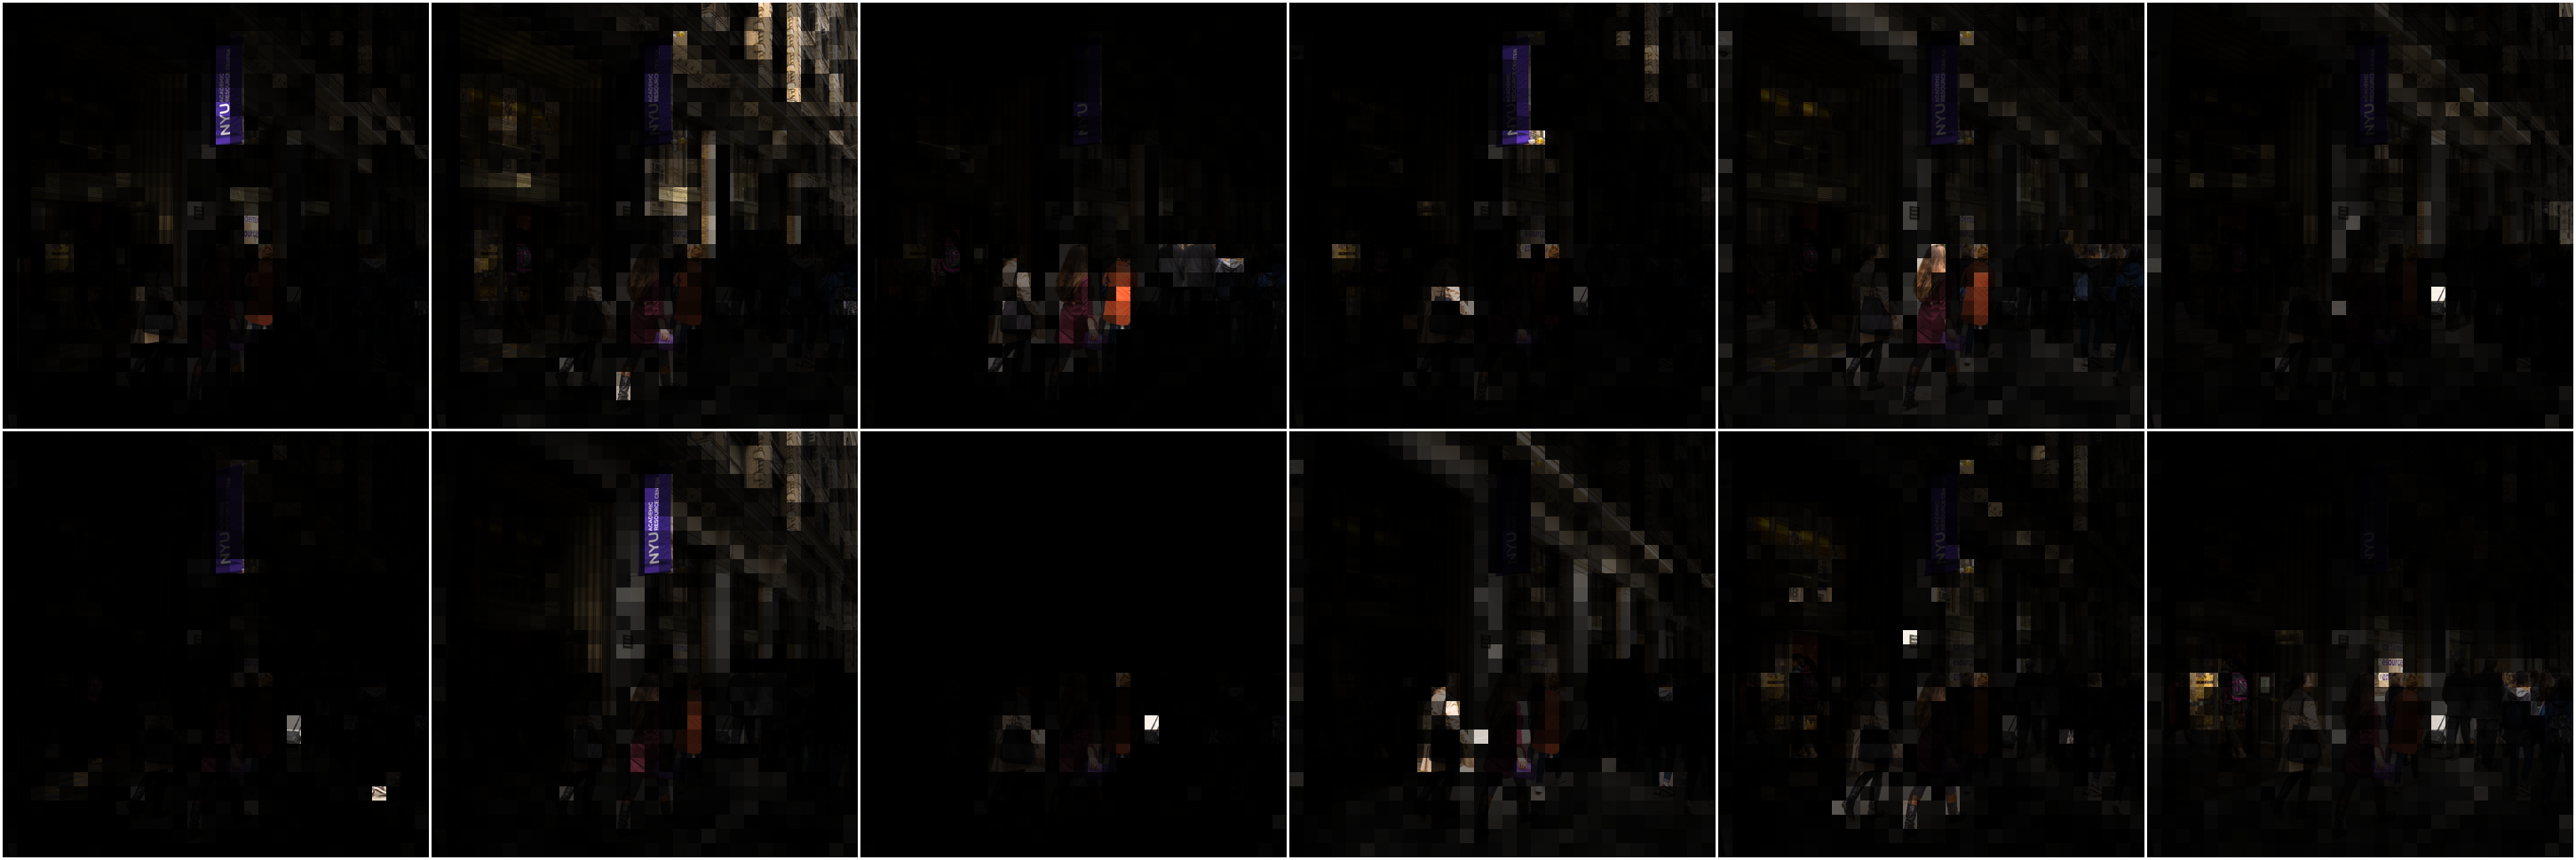

In [9]:
# Apply as heatmap to source image
display(to_pil_image(make_grid(tensor_image*attentions_normalized,
                               pad_value=1., padding=3, nrow=6,
                               normalize=True, scale_each=True)))

We can see that different attention heads focus on distinct elements of the image. Some heads emphasize the NYU banner, while others highlight the building or the people walking by.